In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# Data preprocessing settings
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Loading the dataset
train_val_dataset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                                 download=True, transform=transform)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                            download=True, transform=transform)

# Splitting the training dataset into training and validation sets
train_size = int(0.8 * len(train_val_dataset))
val_size = len(train_val_dataset) - train_size
train_dataset, val_dataset = random_split(train_val_dataset, [train_size, val_size])

# Setting up DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


100%|██████████| 170498071/170498071 [00:01<00:00, 105700576.91it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [ ]:
# FGSM Attack Function
def fgsm_attack(image, epsilon, data_grad):
    # Calculating the sign of the data gradients
    sign_data_grad = data_grad.sign()
    # Creating perturbed image using FGSM formula
    perturbed_image = image + epsilon * sign_data_grad
    # Clamping perturbed image values between 0 and 1
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    return perturbed_image


In [ ]:
# Setting up the model and criteria
from torchvision.models import resnet18

# Checking device availability
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Loading pretrained ResNet18 model
model = resnet18(pretrained=True)

model.fc = nn.Linear(model.fc.in_features, 10)

model.to(device)


In [ ]:

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [ ]:
# Training the model with randomly added FGSM perturbations
num_epochs = 20
epsilon = 0.1

train_losses, val_losses = [], []

for epoch in range(num_epochs):
    # Training
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        # Generating random FGSM perturbations
        data_grad = fgsm_attack(images, epsilon, torch.randn_like(images).to(device))

        optimizer.zero_grad()
        outputs = model(images + data_grad)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    train_losses.append(running_loss / len(train_loader))

    # Validation
    model.eval()
    running_loss = 0.0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
    val_losses.append(running_loss / len(val_loader))

    print(f'Epoch {epoch+1}: Train Loss = {train_losses[-1]:.4f}, Validation Loss = {val_losses[-1]:.4f}')


Epoch 1: Train Loss = 1.0700, Validation Loss = 0.7136
Epoch 2: Train Loss = 0.6875, Validation Loss = 0.6228
Epoch 3: Train Loss = 0.5383, Validation Loss = 0.5801
Epoch 4: Train Loss = 0.4351, Validation Loss = 0.5679
Epoch 5: Train Loss = 0.3538, Validation Loss = 0.5819
Epoch 6: Train Loss = 0.2848, Validation Loss = 0.6091
Epoch 7: Train Loss = 0.2352, Validation Loss = 0.6250
Epoch 8: Train Loss = 0.1999, Validation Loss = 0.6392
Epoch 9: Train Loss = 0.1644, Validation Loss = 0.6898
Epoch 10: Train Loss = 0.1449, Validation Loss = 0.6908
Epoch 11: Train Loss = 0.1135, Validation Loss = 0.7154
Epoch 12: Train Loss = 0.1081, Validation Loss = 0.7413
Epoch 13: Train Loss = 0.0950, Validation Loss = 0.7450
Epoch 14: Train Loss = 0.0854, Validation Loss = 0.7634
Epoch 15: Train Loss = 0.0678, Validation Loss = 0.7796
Epoch 16: Train Loss = 0.0674, Validation Loss = 0.7883
Epoch 17: Train Loss = 0.0611, Validation Loss = 0.8168
Epoch 18: Train Loss = 0.0574, Validation Loss = 0.8157
E

In [ ]:
# Calculating accuracy on test data
correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

test_accuracy = correct / total
print(f'Accuracy of the model on the test images: {test_accuracy * 100:.2f}%')


Accuracy of the model on the test images: 82.36%


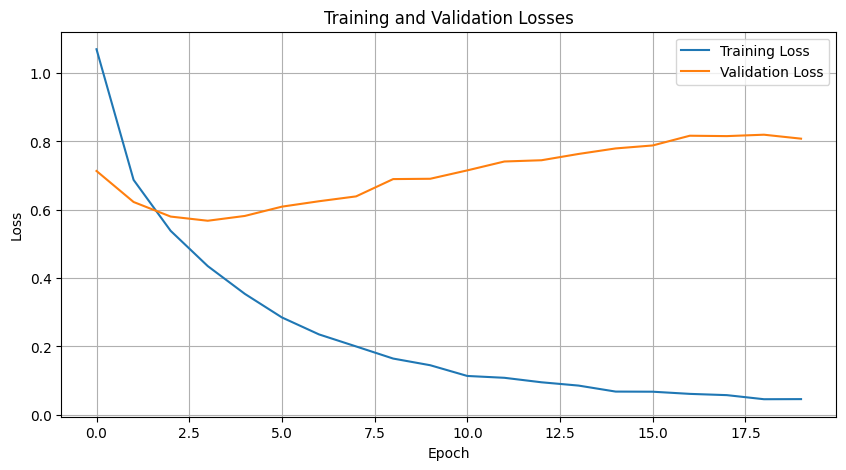

In [ ]:
import matplotlib.pyplot as plt
# Plotting the loss changes for training and validation data
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Losses')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
! pip install umap-learn


In [ ]:
feature_extractor = torch.nn.Sequential(*list(model.children())[:-1])
feature_extractor = feature_extractor.to(device)

In [ ]:
def extract_features(dataloader):
    features = []
    labels = []

    feature_extractor.eval()
    with torch.no_grad():
        for data in dataloader:
            inputs, lbls = data[0].to(device), data[1].to(device)
            output = feature_extractor(inputs)
            features.extend(output.view(output.size(0), -1).cpu().numpy())
            labels.extend(lbls.cpu().numpy())

    return np.array(features), np.array(labels)

# Extracting features
train_features, train_labels = extract_features(train_loader)
test_features, test_labels = extract_features(test_loader)


### UMAP for train data

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


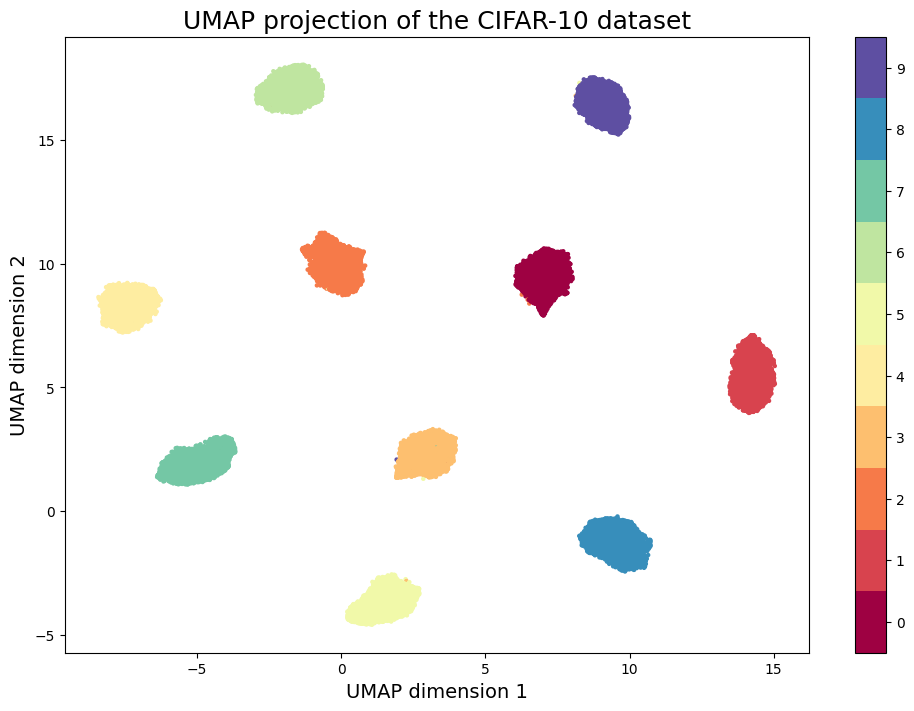

In [ ]:
import umap
# Using UMAP to reduce the dimensionality of features to two dimensions
reducer = umap.UMAP(random_state=42)
umap_embedding = reducer.fit_transform(train_features)

# Visualizing the results
plt.figure(figsize=(12, 8))
plt.scatter(umap_embedding[:, 0], umap_embedding[:, 1], c=train_labels, cmap='Spectral', s=5)
plt.colorbar(boundaries=np.arange(11)-0.5).set_ticks(np.arange(10))
plt.title('UMAP projection of the CIFAR-10 dataset', fontsize=18)
plt.xlabel('UMAP dimension 1', fontsize=14)
plt.ylabel('UMAP dimension 2', fontsize=14)
plt.show()


### UMAP for test data

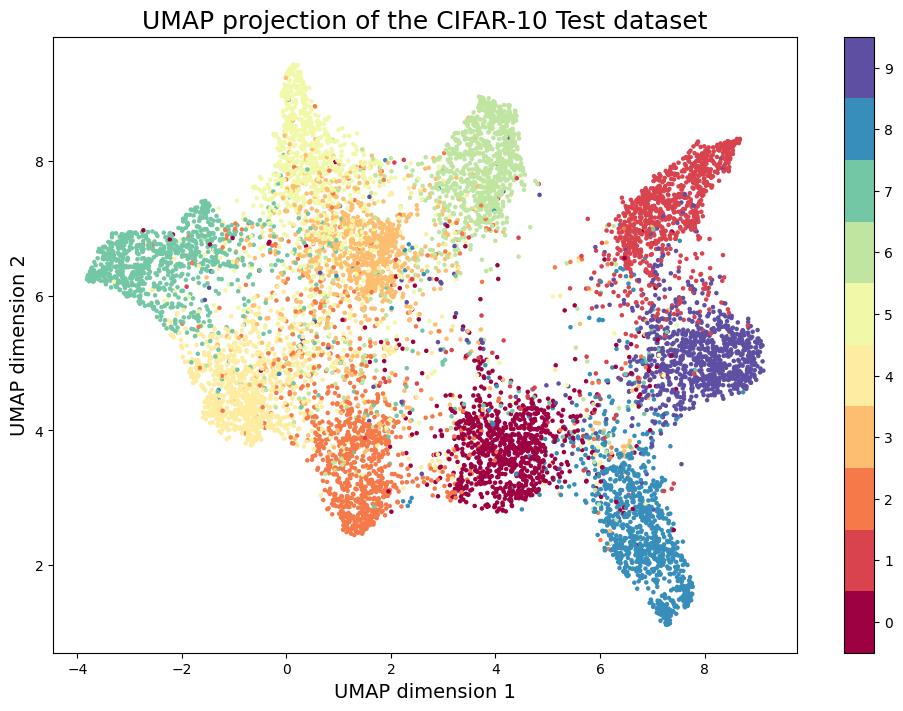

In [ ]:
# Extracting features for test data
test_features, test_labels = extract_features(test_loader)

# Using UMAP to reduce the dimensionality of features to two dimensions for test data
umap_embedding_test = reducer.fit_transform(test_features)

# Visualizing the results for test data
plt.figure(figsize=(12, 8))
plt.scatter(umap_embedding_test[:, 0], umap_embedding_test[:, 1], c=test_labels, cmap='Spectral', s=5)
plt.colorbar(boundaries=np.arange(11)-0.5).set_ticks(np.arange(10))
plt.title('UMAP projection of the CIFAR-10 Test dataset', fontsize=18)
plt.xlabel('UMAP dimension 1', fontsize=14)
plt.ylabel('UMAP dimension 2', fontsize=14)
plt.show()


In [ ]:
# FGSM Attack Function
def fgsm_attack(image, epsilon, data_grad):
    sign_data_grad = data_grad.sign()
    perturbed_image = image + epsilon * sign_data_grad
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    return perturbed_image

epsilon = 0.1

# Device setup
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Calculating model accuracy on adversarial data
correct = 0
total = 0

# Set the model to evaluation mode
model.eval()

# Running FGSM attack on the entire test dataset
for images, labels in test_loader:
    images, labels = images.to(device), labels.to(device)
    images.requires_grad = True

    # Model prediction on test images
    outputs = model(images)
    loss = criterion(outputs, labels)
    model.zero_grad()
    loss.backward()

    # Generating adversarial examples using FGSM
    perturbed_data = fgsm_attack(images, epsilon, images.grad)

    # Model prediction on adversarial examples
    outputs = model(perturbed_data)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()

# Calculating accuracy
accuracy = correct / total
print('Accuracy of the model on the adversarial test images: {:.2f}%'.format(accuracy * 100))


Accuracy of the model on the adversarial test images: 53.23%


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


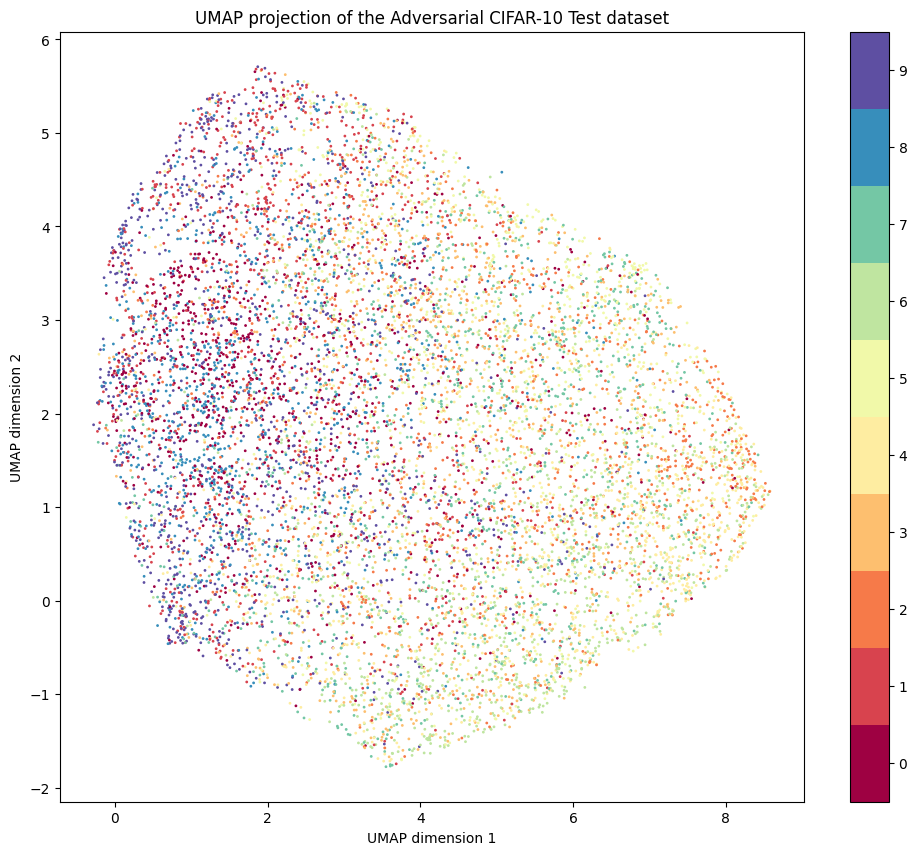

In [ ]:
import torch
import umap
import matplotlib.pyplot as plt
import numpy as np
from torchvision.models import resnet18

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Loading pretrained model
model = resnet18(pretrained=True)
model.fc = torch.nn.Linear(model.fc.in_features, 10)  # Matching with the number of classes in CIFAR-10
model.to(device)
model.eval()

# Extracting features and labels of adversarial samples
adversarial_features = []
adversarial_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        adversarial_features.append(outputs.cpu().numpy())  # Extracting features
        adversarial_labels.append(labels.cpu().numpy())  # Labels

# Converting lists to numpy arrays
adversarial_features = np.concatenate(adversarial_features, axis=0)
adversarial_labels = np.concatenate(adversarial_labels, axis=0)

# Dimensionality reduction with UMAP
reducer = umap.UMAP(random_state=42)
adversarial_umap_embedding = reducer.fit_transform(adversarial_features)

# Plotting the graph
plt.figure(figsize=(12,10))
plt.scatter(adversarial_umap_embedding[:, 0], adversarial_umap_embedding[:, 1], c=adversarial_labels, cmap='Spectral', s=1)
plt.colorbar(boundaries=np.arange(11)-0.5).set_ticks(np.arange(10))
plt.title('UMAP projection of the Adversarial CIFAR-10 Test dataset')
plt.xlabel('UMAP dimension 1')
plt.ylabel('UMAP dimension 2')
plt.show()
